<a href="https://colab.research.google.com/github/joaochenriques/IST---Marine-Currents-and-Tidal-Energy/blob/main/Tidal_Stream/BladeElementMethod/BladeDesign_V04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import subprocess
import pandas as pd
import pathlib
import numpy as np
from scipy.optimize import minimize, root_scalar

def cmdcall( cmd, verbose = False ):
    output = subprocess.getoutput( cmd )
    if verbose: print(output)

if not pathlib.Path("mpl_utils.py").exists():
  cmdcall( "curl -O https://raw.githubusercontent.com/joaochenriques/ipynb_libs/main/mpl_utils.py" )

import matplotlib.pyplot as mpl
import mpl_utils as mut
mut.config_plots()

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

In [6]:
rad2deg = 180/np.pi
deg2rad = np.pi/180

λtip = 12.0
dλ = 0.125
n = int( ( λtip - 0.25 ) / dλ + 1 )
λ_set = np.linspace( 0.25, λtip, n )

## Glauert optimal distribution

C_P = 0.5871


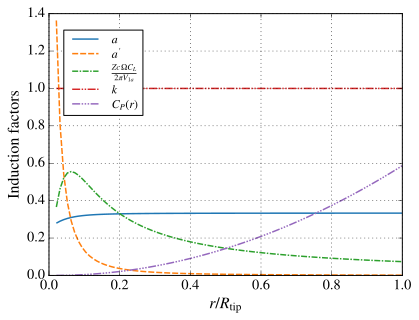

In [7]:
λ_vec  = []
ϕ_vec   = []
a_vec   = []
ap_vec  = []
k_vec   = []
EE_vec  = []
CPr_vec = []
CP_vec  = []

for i, λ in enumerate( λ_set ):

    # TOpt.set_λ( λ )

    func = lambda a: 16 * a**3 - 24 * a**2 + 3 * ( 3 - λ**2 ) * a + ( λ**2 - 1 )
    a = root_scalar(func, bracket=[ 1.0/4.0, 1.0/3.0 ], method='brentq' ).root
    ap = ( 1.0 - 3 * a ) / ( 4 * a - 1 )

    # print( i, _a, a )

    k = 1#TOpt.tip_loss( a, ap, λ )
    ϕ = np.arctan( ( 1 - a ) / ( 1 + ap ) / λ )
    EE  = 4.0 * ap * λ**2 / np.sqrt( ( 1.0 - a )**2 + ( 1.0 + ap )**2 * λ**2 )
    CPr = 8 / λtip**2 * k * ap * ( 1.0 - a ) * λ**3

    λ_vec.append( λ )
    a_vec.append( a )
    ap_vec.append( ap )
    ϕ_vec.append( ϕ )
    k_vec.append( k )
    EE_vec.append( EE )
    CPr_vec.append( CPr )

    if i > 0:
        dλ = λ_vec[i] - λ_vec[i-1]
        CPm = 0.5 * ( CPr_vec[i] + CPr_vec[i-1] )
        CP  = CP_vec[i-1] + CPm * dλ
    else:
        CP = 0.0

    CP_vec.append( CP )

x_vec = np.array( λ_vec ) / λtip

mpl.plot( x_vec, a_vec,  label = r"$a$" )
mpl.plot( x_vec, ap_vec, label = r"$a'$" )
mpl.plot( x_vec, EE_vec, label = r"$\frac{Zc\,\Omega C_L}{2\pi V_{1a}}$" )
mpl.plot( x_vec, k_vec,  label = r"$k$" )
mpl.plot( x_vec, CP_vec, label = r"$C_P(r)$" )

mpl.xlabel( r"$r/R_\mathrm{tip}$")
mpl.ylabel( "Induction factors")
mpl.legend( loc="upper left", fontsize=12, handlelength=2.8, \
            labelspacing=.3, bbox_to_anchor=(0.025,0.96) )
# mpl.xlim( [ 0, 1.015 ] )
# mpl.ylim( [ 0, 1.015 ] )
mpl.grid()
mpl.savefig( "InductionFactors.pdf" )
print( f"C_P = {CP_vec[-1]:.4f}" )

In [8]:
df = pd.DataFrame( { r"$\lambda$": λ_vec,
                     r"$a$": np.round(a_vec,decimals=5),
                     r"$a'$": np.round(ap_vec,decimals=5),
                     r"$C_P$": np.round(CP_vec,decimals=5),
                     r"$\phi$": np.round(ϕ_vec, decimals=2)*rad2deg,
                     r"$\frac{Zc\,\Omega C_L}{2\pi V_{1a}}$": np.round(EE_vec, decimals=5)
                    } )

# print( df.to_latex(index=False,
#                   formatters={"name": str.upper},
#                   float_format="{:.5f}".format,
# ))
df

,$\lambda$,$a$,$a'$,$C_P$,$\phi$,"$\frac{Zc\,\Omega C_L}{2\pi V_{1a}}$"
0,0.250,0.27957,1.36349,0.00000,50.420286,0.36584
1,0.375,0.29008,0.80936,0.00016,46.409581,0.46360
2,0.500,0.29835,0.54276,0.00043,42.398877,0.52050
3,0.625,0.30481,0.39021,0.00082,38.388172,0.54792
4,0.750,0.30988,0.29384,0.00135,35.523383,0.55523
...,...,...,...,...,...,...
90,11.500,0.33315,0.00168,0.53880,3.437747,0.07689
91,11.625,0.33315,0.00164,0.55068,3.437747,0.07607
92,11.750,0.33316,0.00161,0.56268,3.437747,0.07527
93,11.875,0.33316,0.00157,0.57481,3.437747,0.07448


## Computing the turbine blade

C_P = 0.2288


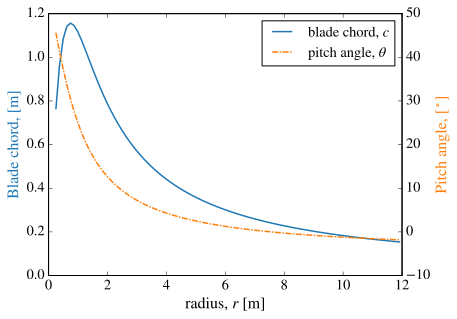

In [9]:
V1a = 2.5
Ω = 24.0 * np.pi / 30.0
Z = 3

α  = 5 * deg2rad
CL = 1.00
CD = 0.05
γ = np.arctan( CD / CL )

EE_factor = 2.0 * np.pi * V1a / ( Z * Ω * CL )

θ_vec = []
r_vec = []
c_vec = []
CP2_vec = []

for i, ( λ, a, ap, ϕ, EE ) in enumerate( zip( λ_vec, a_vec, ap_vec, ϕ_vec, EE_vec ) ):

    θ = ϕ - α
    r = λ * V1a / Ω
    c = EE * EE_factor
    η = np.sin( ϕ - γ ) / np.sin( ϕ )

    if i > 0:
        dλ = λ_vec[i] - λ_vec[i-1]
        CPm = 0.5 * ( CPr_vec[i] + CPr_vec[i-1] )
        CP2 = CP2_vec[i-1] + η * CPm * dλ
    else:
        CP2 = 0.0

    CP2_vec.append( CP2 )

    θ_vec.append( θ )
    r_vec.append( r )
    c_vec.append( c )

ax1 = mpl.gca()
ax1.plot( r_vec, c_vec, mut.linecolors[0], label="blade chord, $c$" )
ax1.set_ylabel( "Blade chord, [m]", color=mut.linecolors[0] )
ax1.set_xlabel( r"radius, $r$ [m]")
ax2 = mpl.gca().twinx()
ax2.plot( r_vec, np.array( θ_vec ) * rad2deg, mut.linecolors[1], \
          dashes=mut.linestyles[2], label=r'pitch angle, $\theta$' )
ax2.tick_params(axis='y' )
ax2.set_ylabel( "Pitch angle, [$^\circ$]", color=mut.linecolors[1] )

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right' )

mpl.savefig( "TurbineDesign.pdf" )

print( f"C_P = {CP2_vec[-1]:.4f}" )